# Szeregi Czasowe (przykład HRV)

Dane pochodzą z https://physionet.org/physiobank/database/fantasia/
Informacje dotyczące zmiennośći rytmu zatokowego: https://en.wikipedia.org/wiki/Heart_rate_variability

In [79]:
import os 
import numpy as np

rr_data = []
for fn in sorted(os.listdir('./data/rr')):
    rr = open('./data/rr/' + fn).readlines()
    rr = [float(rr_i.strip()) for rr_i in rr]
    rr = np.array(rr)
    rr_data.append(rr)
    
print  sorted(os.listdir('./data/rr'))    

['O1.txt', 'O2.txt', 'O3.txt', 'O4.txt', 'O5.txt', 'Y1.txt', 'Y2.txt', 'Y3.txt', 'Y4.txt', 'Y5.txt']


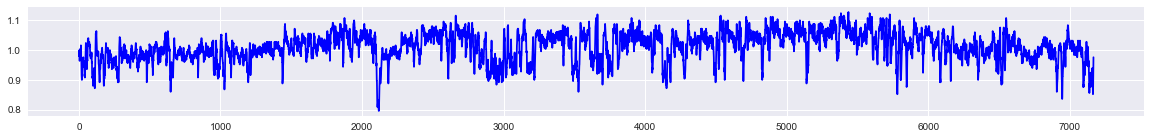

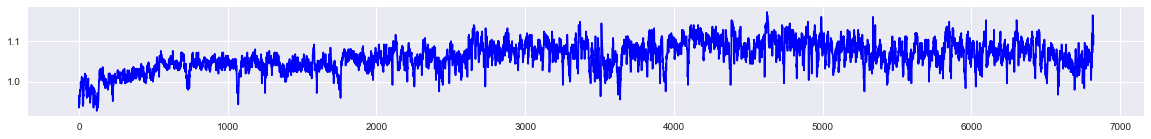

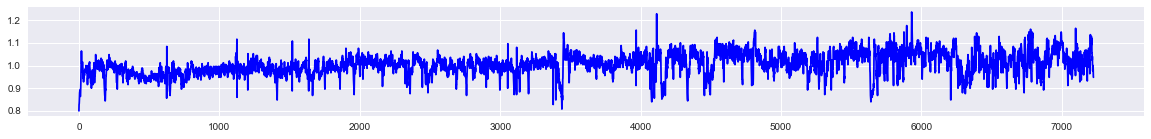

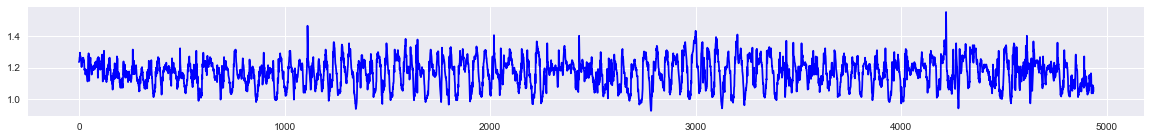

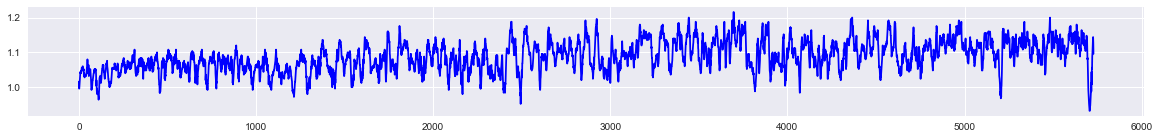

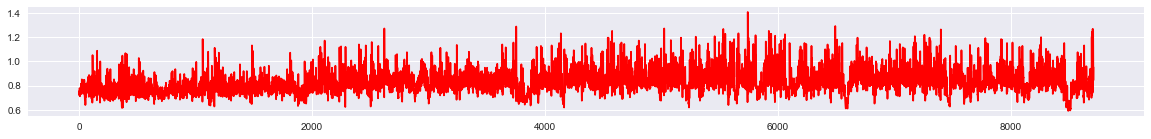

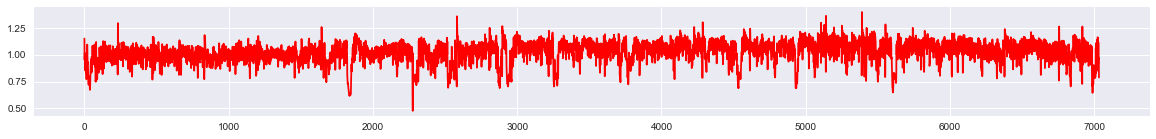

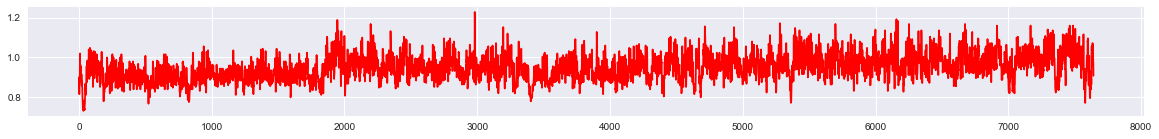

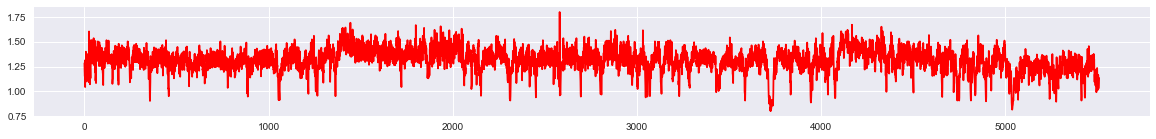

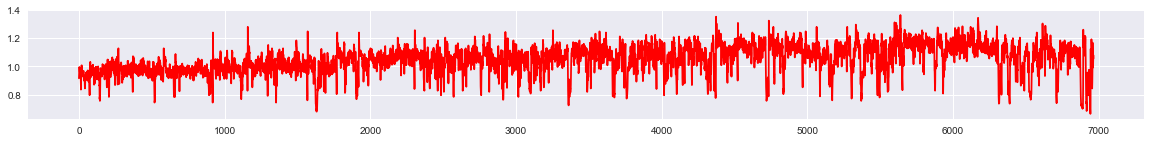

In [80]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(20,2))
    plt.plot(rr_data[i], c ='b' if i<5 else 'r')

plt.show()

In [84]:
def adnn(rr):
    return np.mean(rr)

def sdnn(rr):
    d_rr = rr[1:] - rr[:-1]
    return d_rr.std()

def rmssd(rr):
    d_rr = rr[1:] - rr[:-1]
    return np.sqrt((d_rr**2).mean())

def nn50(rr):
    dd_r = rr[1:] - rr[:-1]
    return np.sum(dd_r < 0.05)

def pnn50(rr):
    dd_r = np.abs(rr[1:] - rr[:-1])
    return float(np.sum(dd_r < 0.05)) / np.sum(dd_r >= 0.05)

def nn20(rr):
    dd_r = np.abs(rr[1:] - rr[:-1])
    return np.sum(dd_r < 0.05)

def pnn20(rr):
    dd_r = rr[1:] - rr[:-1]
    return float(np.sum(dd_r < 0.02)) / np.sum(dd_r >= 0.02)

metrics = [adnn, sdnn, rmssd, nn50, pnn50, nn20, pnn20]



In [85]:
import pandas as pd


data = []
for subject_i in range(10):
    rr = rr_data[subject_i]
    row = {'age' : 'old' if subject_i<5 else 'young'}
    for metric in metrics:
        # use name of the function as column name
        row[metric.__name__] = metric(rr)
    data.append(row)

df_hrv = pd.DataFrame(data)
df_hrv

,adnn,age,nn20,nn50,pnn20,pnn50,rmssd,sdnn
0,1.011486,old,7124,7162,8.721845,173.756098,0.015327,0.015327
1,1.061791,old,6778,6803,8.571629,183.189189,0.015326,0.015326
2,1.003862,old,6977,7068,4.647059,31.286996,0.023380,0.023380
3,1.165945,old,4306,4591,3.456443,7.117355,0.037666,0.037666
4,1.087915,old,5717,5720,19.362989,1143.400000,0.011389,0.011389
5,0.830243,young,4559,6792,1.653870,1.116854,0.093013,0.093013
6,1.028951,young,3841,5466,1.691510,1.213586,0.074765,0.074765
7,0.951703,young,6586,7074,2.663946,6.296367,0.034675,0.034675
8,1.313063,young,1819,3691,1.348271,0.493891,0.106917,0.106917
9,1.047909,young,5000,6036,1.935990,2.596054,0.054845,0.054845


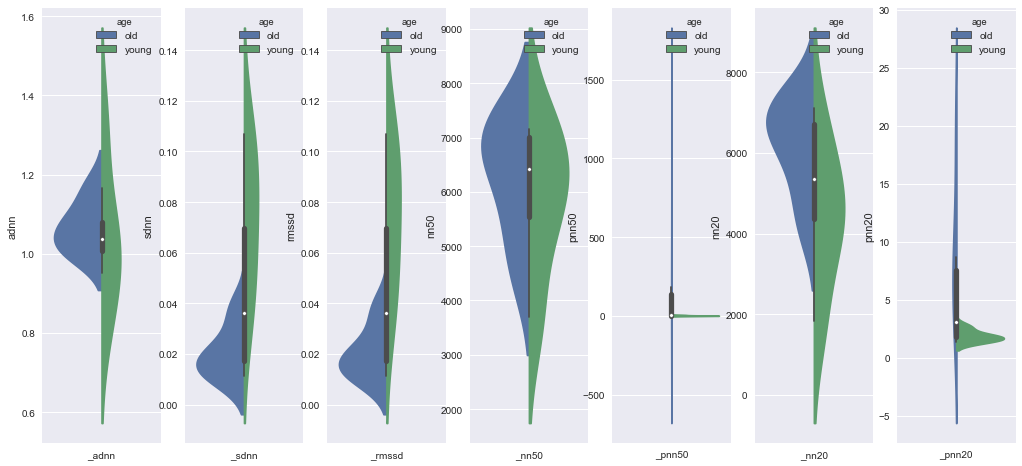

In [87]:
import seaborn as sn

fig = plt.figure(figsize=(20, 8))
for plot_i, m in enumerate(metrics):
    fig.add_subplot(1, len(metrics)+1, plot_i + 1)
    sn.violinplot(data=df_hrv, y=m.__name__, x=['_'+m.__name__]*10,  hue ='age', split=True)
    
plt.show()

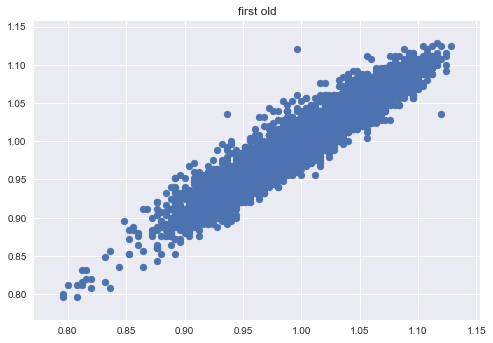

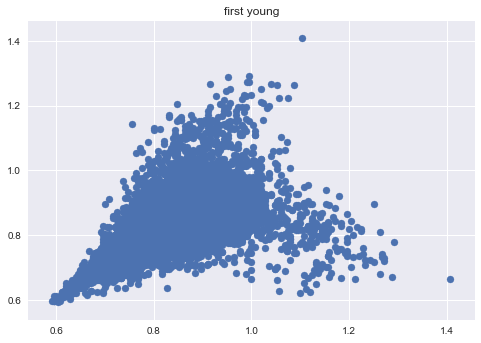

In [92]:
#poincare plot
rr = rr_data[0]
plt.figure()
P = np.vstack([rr[1:], rr[:-1]]).T
plt.scatter(P[:,0], P[:,1])
plt.title('first old')
rr = rr_data[5]
plt.figure()
P = np.vstack([rr[1:], rr[:-1]]).T
plt.scatter(P[:,0], P[:,1])
plt.title('first young')
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 56
         Gradient evaluations: 7


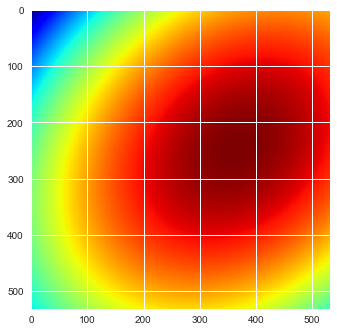

In [114]:
from scipy import optimize
#ellipsis fitting by quadratic equation fitting

rr = rr_data[0]
P = np.vstack([rr[1:], rr[:-1]]).T

def cost(u):
    A,B,C,D,E,F = u
    x, y = P.T
    err = A*x**2 + B*x*y + C*y**2 +D*x + E*y + F
    return np.mean(err ** 2)

(A,B,C,D,E,F) = optimize.fmin_bfgs(cost, x0 = np.array([1.,1.,1.,1.,1.,1.]))

x_min, x_max = P[:, 1].min() - 0.1, P[:, 1].max() + 0.1
y_min, y_max = P[:, 0].min() - 0.1, P[:, 0].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                     np.arange(y_min, y_max, 0.001))

N = xx.shape
xx, yy = xx.ravel(), yy.ravel()
z = A*xx**2 + B*xx*yy + C*yy**2 +D*xx + E*yy + F
z = z / z.max()
plt.imshow(z.reshape(N), cmap='jet')
plt.show()